# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/ml/edyo/project/utils" .
!cp -r "/content/drive/My Drive/ml/edyo/project/output.zip" .
!unzip /content/output.zip -d /content/output

In [ ]:
import pandas as pd
import numpy as np
import re
from IPython.display import display_html

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

import matplotlib.pyplot as plt
import cv2

from utils.video_reader import VideoReader

import os
import tqdm
import sys
import glob

In [ ]:
dataset_path = f"/content/drive/My Drive/ml/edyo/project/dataset"
output_path = f"./output/output"
demo_videos_path = f"/content/drive/My Drive/ml/edyo/project/output/video"
demo_gif_path = f"/content/drive/My Drive/ml/edyo/project/output/gif"

In [ ]:
annotations_df = pd.read_csv(f"{dataset_path}/Milestone 1 - Dataset.csv")
annotated_df = annotations_df[annotations_df.iloc[:, 1].notna()]
face_annotations_df = annotated_df.iloc[1:, [0,2,3,4]].copy()
face_annotations_df.columns = ["video_name", "no_face", "one_face", "multiple_faces"]
face_annotations_df.reset_index(drop=True, inplace=True)
face_annotations_df[:5]

,video_name,no_face,one_face,multiple_faces
0,video_1_0000.mp4,NaN,+,NaN
1,video_1_0001.mp4,+,+,NaN
2,video_1_0002.mp4,NaN,+,NaN
3,video_1_0003.mp4,NaN,+,NaN
4,video_1_0004.mp4,NaN,+,NaN


In [ ]:
video_qualities = ["low", "medium", "high"]

# Description

**Face recognition**

The goal of this research is try face recognition tools on video with different augmentations from online education domain area. 

For this purpose two face recognition tools were selected:
 - [face_recognition](https://github.com/ageitgey/face_recognition)
 - [insightface](https://github.com/deepinsight/insightface)

As a test dataset were filmed several videos with person are watching a video course. Those videos were cropped into small segments of 15s and 60fps each, original resolution is 1920x1080. Also every video has versions with medium resolution (960x540) and low resolution (640x360).




# Test dataset preview

Dataset: https://drive.google.com/drive/folders/1WK6WrvrwhtXKsRJO2H_f2rS6sETghcQB?usp=sharing  

To simplify accuracy measurement process we selected videos with only one person without cases of disappering from the camera.
Also these videos have "ideal" conditions: there is only one person, person's face is visible, normal lighting conditions, background is not cluttered. 

---

Number of videos: 49  
Duration: ~15s  
Resolutions: 1920x1080, 960x540, 540x360  

---


## Preview of test video

In [ ]:
#@title
quality = "medium"
video_names = ["video_1_0000.mp4", "video_1_0009.mp4", "video_2_0000.mp4"]
for video_name in video_names:
    with open(f"{dataset_path}/gif/{quality}_{video_name}.gif",'rb') as f:
        display.Image(data=f.read(), format='png', width="500")

## Random frames from test videos

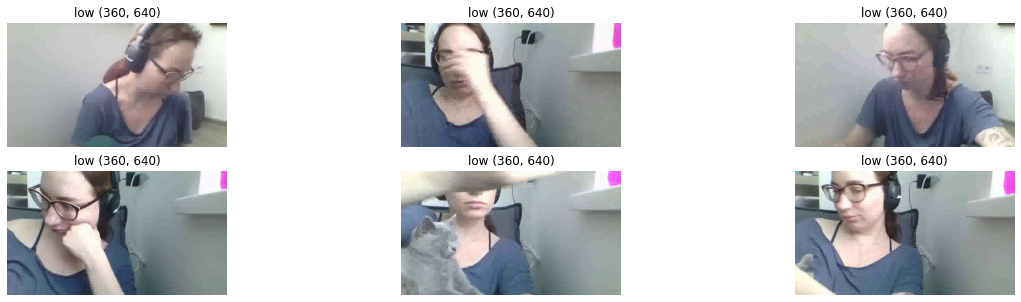

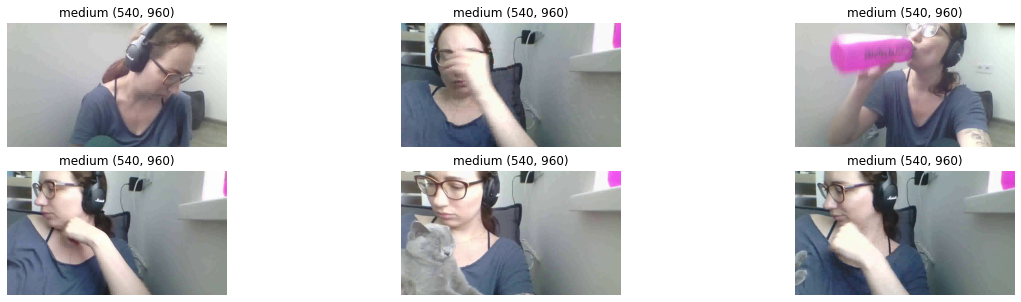

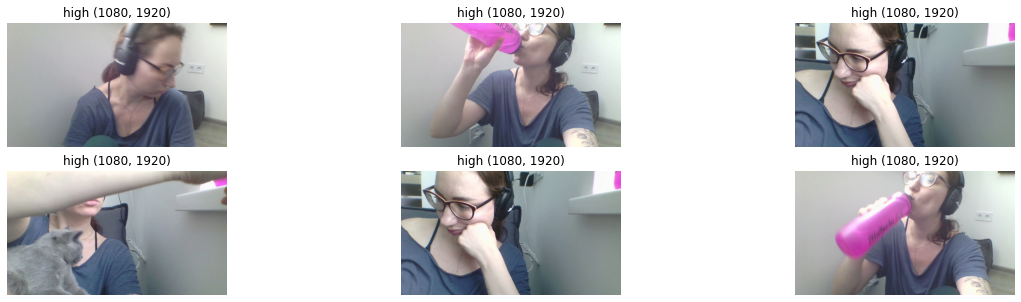

In [ ]:
#@title
def show_frames(videos_path, folder_path, folder, n_videos=6):
    csv_list = os.listdir(folder_path)
    frames = []
    for csv_name in csv_list:
        if len(frames) >= n_videos: break
        csv = pd.read_csv(f"{folder_path}/{csv_name}")
        csv = csv[csv["process_time"].notna()]
        if len(csv) == 0: continue
        
        video_name = re.search('video(.+?).mp4', csv_name).group(0)
        vr = VideoReader(f"{videos_path}/{video_name}")
        
        n_frame = int(csv.sample(1).iloc[0]["frame"])
        frame = vr.get_frame(n_frame)
        if frame is not None:
            frames.append(frame)
        
    fig, ax = plt.subplots(n_videos//3, 3, figsize=(20,5))
    ax = ax.flatten()
    for i, frame in enumerate(frames):
        ax[i].imshow(frame[:,:,::-1]), ax[i].set_title(f"{folder} {frame.shape[:2]}"), ax[i].axis("off")
            
    
for quality in video_qualities:
    show_frames(f"{dataset_path}/video/{quality}", f"{output_path}/wrong/{quality}", quality)

## Index

Face recognition process consists of two main steps: extract face features and using those feature find person in the data storage. 

Matching face features is performed using index file. This index is build using [faiss](https://github.com/facebookresearch/faiss) tool on [LWS](https://www.kaggle.com/jessicali9530/lfw-dataset) dataset. Also to this index was added photo of a person from test videos.

## Photo

This photo was added to index to match person from test video.

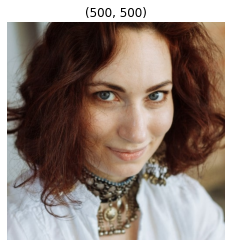

In [ ]:
#@title
image = cv2.imread(f"{dataset_path}/gans Hanna Shubina.jpg")[:,:,::-1]
plt.imshow(image)
plt.axis("off")
plt.title(image.shape[:2]);

# Accuracy

In [ ]:
#@title
pd.set_option('display.precision', 2)

def process_output(recognizer_prefix, output_path, folder, video_list, person_name, title):
    summary_df = pd.DataFrame([], columns=["skip_frames", "wrong_face_detection_%", "wrong_person_detection_%"])
    os.makedirs(f"{output_path}/wrong/{folder}", exist_ok=True)
    
    output_files = glob.iglob(f"{output_path}/{folder}/{recognizer_prefix}video_*.csv", recursive=True)
    for output_file_path in output_files:
        file_name = os.path.basename(output_file_path).replace(recognizer_prefix, '')
        skip_frames = file_name.split("_")[-1][:-4]
        video_name = "_".join(file_name.rsplit("_")[:-2])
        if video_name not in video_list: continue

        output_df = pd.read_csv(output_file_path)
        processed_frames = len(output_df)
        wrong_face_detection = len(output_df[output_df["num_faces"] != 1])
        wrong_person_detection = len(output_df[output_df["person_name"] != person_name])
        summary_df = summary_df.append({"skip_frames": skip_frames, 
                                        "wrong_face_detection_%": wrong_face_detection/processed_frames*100, 
                                        "wrong_person_detection_%": wrong_person_detection/processed_frames*100}, 
                                       ignore_index=True)
        
    agg_df = summary_df.groupby(["skip_frames"]).agg({'wrong_face_detection_%': ['mean'],
                                                      'wrong_person_detection_%': ['mean']})
    return agg_df.style\
    .set_table_attributes("style='display:inline'")\
    .set_caption(f"{title}, {folder} folder")

one_face_only_list = face_annotations_df[face_annotations_df["no_face"].isna() 
                                       & face_annotations_df["one_face"].notna() 
                                       & face_annotations_df["multiple_faces"].isna()]["video_name"].unique()
for quality in video_qualities:
    fr_df = process_output("fr_", output_path, quality, one_face_only_list, "Hanna Shubina", "face_recognition")
    if_df = process_output("if_", output_path, quality, one_face_only_list, "Hanna Shubina", "insightface")
    display_html(fr_df._repr_html_() + if_df._repr_html_() + "<hr>", raw=True)    

,wrong_face_detection_%,wrong_person_detection_%
,mean,mean
skip_frames,,
10,2.29,27.27
20,2.38,27.03
30,1.90,27.98
5,2.32,27.13
,wrong_face_detection_%,wrong_person_detection_%
,mean,mean
skip_frames,,
10,1.95,4.88


,wrong_face_detection_%,wrong_person_detection_%
,mean,mean
skip_frames,,
10,1.80,19.71
20,1.95,19.83
30,1.63,19.05
5,1.78,20.10
,wrong_face_detection_%,wrong_person_detection_%
,mean,mean
skip_frames,,
10,0.99,3.26


,wrong_face_detection_%,wrong_person_detection_%
,mean,mean
skip_frames,,
10,1.45,13.61
20,1.66,14.77
30,1.29,15.79
5,1.47,12.80
,wrong_face_detection_%,wrong_person_detection_%
,mean,mean
skip_frames,,
10,0.34,3.55


# Time

In [ ]:
#@title
pd.set_option('display.precision', 2)

def process_summary(recognizer_prefix, summary_path, title, folder):
    summary_df = pd.read_csv(summary_path)
    selected_by_folder_df = summary_df[summary_df["video_path"].str.contains(folder)]
    agg_df = selected_by_folder_df.groupby(["skip_frames"]).agg(
        {'video_length_s': ['sum', 'mean'],
         'processed_time': ['sum', 'mean'],
         'output_fps': 'mean'})
    
    agg_df = agg_df.round(2)
    
    return agg_df.style\
        .set_table_attributes("style='display:inline'")\
        .set_caption(f"{title}, {folder} folder")
    
for quality in video_qualities:
    fr_df = process_summary("fr_", f"{output_path}/fr_summary.csv", "face_recognition", quality)
    if_df = process_summary("if_", f"{output_path}/if_summary.csv", "insightface", quality)
    display_html(fr_df._repr_html_() + if_df._repr_html_() + "<hr>", raw=True)

face_recognition, low folder video_length_s processed_time output_fps sum mean sum mean mean skip_frames 
 
 5 
 778.13 
 14.96 
 594.13 
 11.43 
 79.23 
 
 
 10 
 778.13 
 14.96 
 327.20 
 6.29 
 143.84 
 
 
 20 
 778.13 
 14.96 
 174.04 
 3.35 
 270.50 
 
 
 30 
 778.13 
 14.96 
 119.26 
 2.29 
 394.67 
 
 insightface, low folder video_length_s processed_time output_fps sum mean sum mean mean skip_frames 
 
 5 
 778.13 
 14.96 
 288.05 
 5.54 
 175.05 
 
 
 10 
 778.13 
 14.96 
 142.36 
 2.74 
 330.77 
 
 
 20 
 778.13 
 14.96 
 80.23 
 1.54 
 587.80 
 
 
 30 
 778.13 
 14.96 
 59.71 
 1.15 
 789.18

face_recognition, medium folder video_length_s processed_time output_fps sum mean sum mean mean skip_frames 
 
 5 
 778.13 
 14.96 
 988.59 
 19.01 
 47.58 
 
 
 10 
 778.13 
 14.96 
 543.05 
 10.44 
 86.59 
 
 
 20 
 778.13 
 14.96 
 290.63 
 5.59 
 162.07 
 
 
 30 
 778.13 
 14.96 
 201.06 
 3.87 
 234.20 
 
 insightface, medium folder video_length_s processed_time output_fps sum mean sum mean mean skip_frames 
 
 5 
 778.13 
 14.96 
 296.07 
 5.69 
 158.58 
 
 
 10 
 778.13 
 14.96 
 172.93 
 3.33 
 271.45 
 
 
 20 
 778.13 
 14.96 
 103.86 
 2.00 
 452.80 
 
 
 30 
 778.13 
 14.96 
 76.78 
 1.48 
 612.49

face_recognition, high folder video_length_s processed_time output_fps sum mean sum mean mean skip_frames 
 
 5 
 928.25 
 17.85 
 3323.89 
 63.92 
 16.89 
 
 
 10 
 928.25 
 17.85 
 1764.59 
 33.93 
 31.81 
 
 
 20 
 928.25 
 17.85 
 872.36 
 16.78 
 64.36 
 
 
 30 
 928.25 
 17.85 
 602.87 
 11.59 
 93.10 
 
 insightface, high folder video_length_s processed_time output_fps sum mean sum mean mean skip_frames 
 
 5 
 928.25 
 17.85 
 409.54 
 7.88 
 136.89 
 
 
 10 
 928.25 
 17.85 
 225.99 
 4.35 
 248.01 
 
 
 20 
 928.25 
 17.85 
 115.93 
 2.23 
 483.43 
 
 
 30 
 928.25 
 17.85 
 79.93 
 1.54 
 701.26

# Visualization

Here are some examples how face recognition works in real life.

In [ ]:
#@title
quality = "medium"
video_names = ["video_1_0000.mp4", "video_1_0009.mp4", "video_2_0000.mp4"]
for video_name in video_names:
    with open(f"{demo_gif_path}/{quality}_{video_name}.gif",'rb') as f:
        display.Image(data=f.read(), format='png', width="500")

# Summary

1. *insightface* library provides better accuracy and performing time than *face_rocognition*.  
1. *face_recognition* harder to setup to use GPU than *insightface*. 
1. For *insightface* image_shape matters (default is 640x640): processing frames with resolution are closer to image_shape provides better results.  
1. Accurate results are provided on frames with forward facing person when eyes,nose and lips are visible, in other words, if we have wrong face landmark detection we'll get bad recognition result.

# What's next

The next step is could be extend the dataset with noisy videos, bad lighting conditions etc. to test *insightface* library and get some intuitions how we can improve recognition results for our domain area.